In [4]:
import netCDF4 as nc
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import shapely
from shapely.geometry import Point
import xarray as xr



In [2]:
# mm1=xr.open_dataset("RF25_ind1951_2022_yday.nc")['RAINFALL']
# mm=mm1.rio.write_crs("EPSG:4326", inplace=True)
# mk=mm.squeeze().to_dataframe().reset_index()


In [6]:
mm1=xr.open_dataset("../RF25_ind1951_2023_ymonmean.nc")['RAINFALL']
mm=mm1.rio.write_crs("EPSG:4326", inplace=True)
mk=mm.squeeze().to_dataframe().reset_index()


In [7]:
file="IND_dist.geojson"
gdf1 = gpd.read_file(file)
gdf = gdf1.to_crs("EPSG:4326")
geometry_column = gdf['geometry']
od=gdf#[gdf['District']=='J>JAPUR']
od['District']=od['District'].str.replace('>', 'A', regex=False)


In [8]:
mk['geometry'] = mk.apply(lambda row: Point(row.LONGITUDE, row.LATITUDE), axis=1)
geometry = [Point(xy) for xy in zip(mk['LONGITUDE'], mk['LATITUDE'])]
gdf = gpd.GeoDataFrame(mk, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)


,TIME,LATITUDE,LONGITUDE,spatial_ref,RAINFALL,geometry
0,2023-01-31,6.5,66.50,0,NaN,POINT (66.5 6.5)
1,2023-01-31,6.5,66.75,0,NaN,POINT (66.75 6.5)
2,2023-01-31,6.5,67.00,0,NaN,POINT (67 6.5)
3,2023-01-31,6.5,67.25,0,NaN,POINT (67.25 6.5)
4,2023-01-31,6.5,67.50,0,NaN,POINT (67.5 6.5)
...,...,...,...,...,...,...
208975,2023-12-31,38.5,99.00,0,NaN,POINT (99 38.5)
208976,2023-12-31,38.5,99.25,0,NaN,POINT (99.25 38.5)
208977,2023-12-31,38.5,99.50,0,NaN,POINT (99.5 38.5)
208978,2023-12-31,38.5,99.75,0,NaN,POINT (99.75 38.5)


In [9]:

gdf['RAINFALL'] = gdf['RAINFALL'].round(2)
intersected_gdf = gpd.sjoin(gdf,od, how="inner", predicate="intersects")


In [10]:
var1=intersected_gdf.groupby(['District','TIME'])['RAINFALL'].mean().reset_index()
var1=pd.merge(var1,od[['District','geometry']],how='left',on='District')
var1 = gpd.GeoDataFrame(var1, geometry=var1.geometry)
# output_path = "rfclim.geojson"
var1['RAINFALL']=var1['RAINFALL'].round(2)
# var1['TIME']=var1['TIME'].astype(str)

var1['District'] = var1['District'].str.replace('|', 'I', regex=False)
var1['District'] = var1['District'].str.replace('@', 'A', regex=False)

var1['TIME'] = pd.to_datetime(var1['TIME']).dt.strftime('%b').str.lower()

time=var1['TIME']
dist=var1['District'].unique()


In [11]:
var1.iloc[[15,20]]

,District,TIME,RAINFALL,geometry
15,AGAR MALWA,apr,0.05,"MULTIPOLYGON (((76.18552 24.32928, 76.21497 24..."
20,AGAR MALWA,sep,5.23,"MULTIPOLYGON (((76.18552 24.32928, 76.21497 24..."


In [12]:
# import numpy as np
# np.array(var1).nbytes / (1024 ** 2)
# var1.memory_usage(deep=True).sum() / (1024 ** 2)

In [13]:
var1

,District,TIME,RAINFALL,geometry
0,ADILABAD,jan,0.28,"MULTIPOLYGON (((78.33565 19.88358, 78.38067 19..."
1,ADILABAD,feb,0.21,"MULTIPOLYGON (((78.33565 19.88358, 78.38067 19..."
2,ADILABAD,mar,0.51,"MULTIPOLYGON (((78.33565 19.88358, 78.38067 19..."
3,ADILABAD,apr,0.45,"MULTIPOLYGON (((78.33565 19.88358, 78.38067 19..."
4,ADILABAD,may,0.61,"MULTIPOLYGON (((78.33565 19.88358, 78.38067 19..."
...,...,...,...,...
8503,ZUNHEBOTO,aug,10.46,"MULTIPOLYGON (((94.47887 26.29356, 94.51599 26..."
8504,ZUNHEBOTO,sep,7.40,"MULTIPOLYGON (((94.47887 26.29356, 94.51599 26..."
8505,ZUNHEBOTO,oct,3.76,"MULTIPOLYGON (((94.47887 26.29356, 94.51599 26..."
8506,ZUNHEBOTO,nov,0.81,"MULTIPOLYGON (((94.47887 26.29356, 94.51599 26..."


<Axes: >

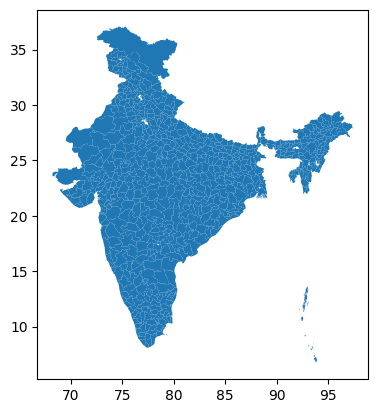

In [14]:
var1[var1['TIME']=='aug'].plot()

# var1['TIME']=var1['TIME'].astype(str)

# var1.to_file("output.geojson")



In [16]:
for i in range(0,701):
    var3=var1[var1['District']==dist[i]]

    # var3['TIME'] = pd.to_datetime(var3['TIME'] + '-2020', format='%d-%b-%Y')
    var3_sorted = var3.sort_values(by='TIME')

    # var3_sorted['TIME'] = var3_sorted['TIME'].dt.strftime('%b')

    # var3_sorted.reset_index(drop=True, inplace=True)


    var4=var3[['TIME','RAINFALL']].copy()
    dis=dist[i]
    filename=f"{dis}.json"
    # print(filename)
    (var4[['TIME','RAINFALL']]).to_json(filename)


In [17]:
for i in range(0,12):
    var2=var1[var1['TIME']==time[i]]

    time1=time[i]
    filename=f"{time1}.geojson"
    print(filename)
    var2.to_file(filename, driver='GeoJSON')





jan.geojson
feb.geojson
mar.geojson
apr.geojson
may.geojson
jun.geojson
jul.geojson
aug.geojson
sep.geojson
oct.geojson
nov.geojson
dec.geojson


In [ ]:
time=pd.to_datetime(var1['TIME'][i]).strftime('%d_%b').lower()
filename=f"{var1['District'][0]}_{time}.geojson"
# var1.to_file(output_path, driver='GeoJSON')
filename

In [ ]:
var1.iloc[[10]].to_file(output_path, driver='GeoJSON')

In [ ]:
import gzip
import json
var1['TIME']=var1['TIME'].astype(str)

geojson_str=var1.to_json()
compressed_geojson = gzip.compress(geojson_str.encode('utf-8'))
with open('output_file.geojson.gz', 'wb') as f:
    f.write(compressed_geojson)



In [18]:
var1.to_file(output_path, driver='GeoJSON')

In [ ]:
var1[var1['District']=="CUTTACK"]

In [ ]:
od

In [19]:
def netcdf_to_gdf(netcdf_file):
    # Open the NetCDF file
    dataset = nc.Dataset(netcdf_file, mode='r')

    # Extract data variables
    lon_var = dataset['LONGITUDE'][:]
    lat_var = dataset['LATITUDE'][:]
    
    polygons = []

    for j, row in enumerate(lon_var):
        for i, value in enumerate(row):
            if not np.isnan(value):  # Ensure the point is valid (not NaN)
                poly_coords = [(lon, lat) for lon, lat in zip(row, lat_var[:, i])]
                polygons.append(Polygon(poly_coords))

    # Create a GeoDataFrame from the polygons
    gdf_netcdf = gpd.GeoDataFrame(geometry=polygons)

    return gdf

def shapefile_to_gdf(shapefile):
    # Read the shapefile using geopandas
    gdf_shape = gpd.read_file(shapefile)
    
    return gdf_shape

def netcdf_and_shapefile_to_geojson(netcdf_file, shapefile, geojson_file):
    # Convert NetCDF data to GeoDataFrame
    gdf_netcdf = netcdf_to_gdf(netcdf_file)

    # Convert Shapefile to GeoDataFrame
    gdf_shape = shapefile_to_gdf(shapefile)

    # Perform any necessary spatial operations or filtering here

    # Write the combined GDF to a GeoJSON file
    gdf_netcdf.to_file(geojson_file, driver='GeoJSON')



In [ ]:
mm=netcdf_to_gdf(netcdf_file)

In [ ]:
if __name__ == "__main__":
    netcdf_file = 'RF25_ind1951_2022_monavg.nc'  # Path to your NetCDF file
    shapefile = 'SUBDISTRICT_BOUNDARY.shp'     # Path to your shapefile
    geojson_file = 'output.geojson'              # Desired output GeoJSON file

    netcdf_and_shapefile_to_geojson(netcdf_file, shapefile, geojson_file)

In [56]:
import xarray as xr
mm1=xr.open_dataset(netcdf_file)['RAINFALL']
mm=mm1.rio.write_crs("EPSG:4326", inplace=True)

In [57]:
fp='SUBDISTRICT_BOUNDARY.shx'
gdf = gpd.read_file(fp)
gdf = gdf.to_crs(mm.rio.crs)

In [92]:
gdf['STATE']=="ODISHA"
odisha_gdf = gdf[gdf['STATE']=="ODISHA"]
# clipped_data = mm1.rio.clip(odisha_gdf.geometry.apply(lambda geom: geom.buffer(0)), odisha_gdf.crs)

In [111]:
clipped_values = clipped_data.values.flatten()


In [109]:
clipped_data = mm.rio.clip(odisha_gdf.geometry.values,  "epsg:4326", drop=True, invert=False)

In [ ]:
clipped_values

In [ ]:
clipped_data